In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl

In [9]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs = 8

In [3]:
prefix = '/data/codec/pilot.amo.oct19/mrna/'

In [4]:
path = prefix + 'pkls/concat.freemuxed.dimred.no5.pkl'

# with open(path,'wb') as file:
#     pkl.dump(concat, file, protocol=4) # protocol=4 required for files larger than 4 GiB
    
with open(path,'rb') as file:
    concat = pkl.load(file)

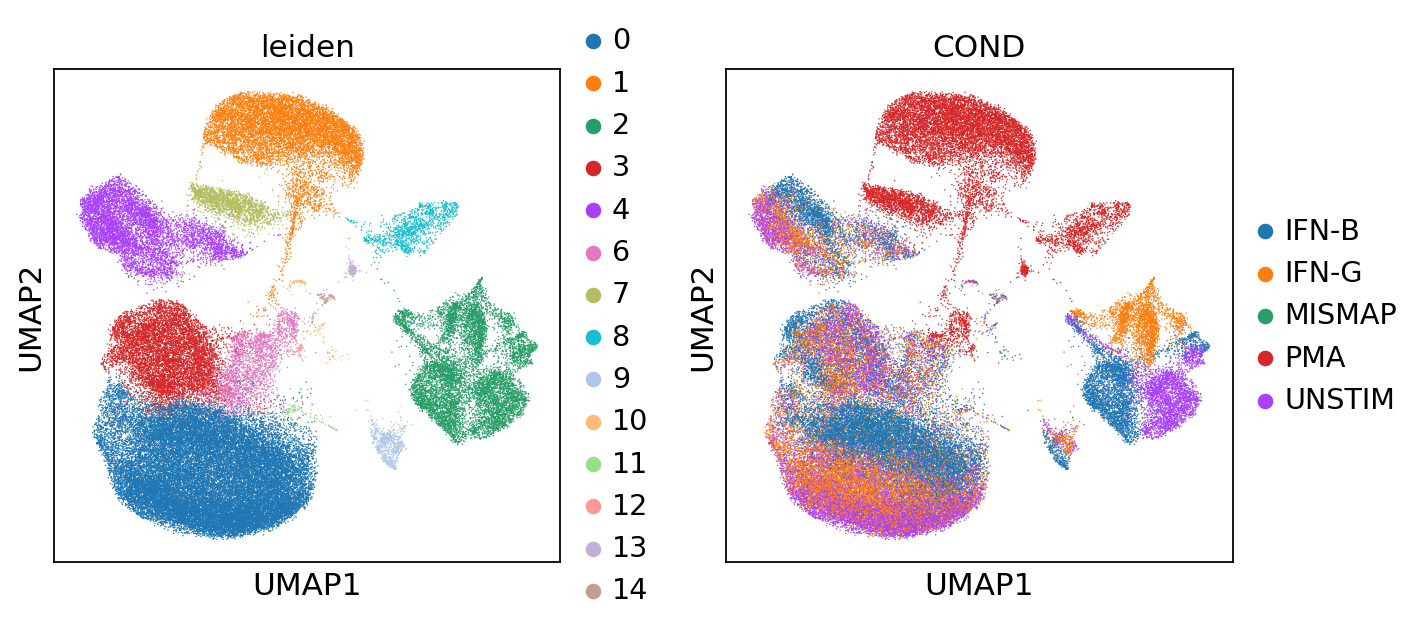

In [25]:
sc.pl.umap(concat, color=['leiden','COND'])

In [14]:
batches = concat.obs['batch'].unique() # get a list of the batches

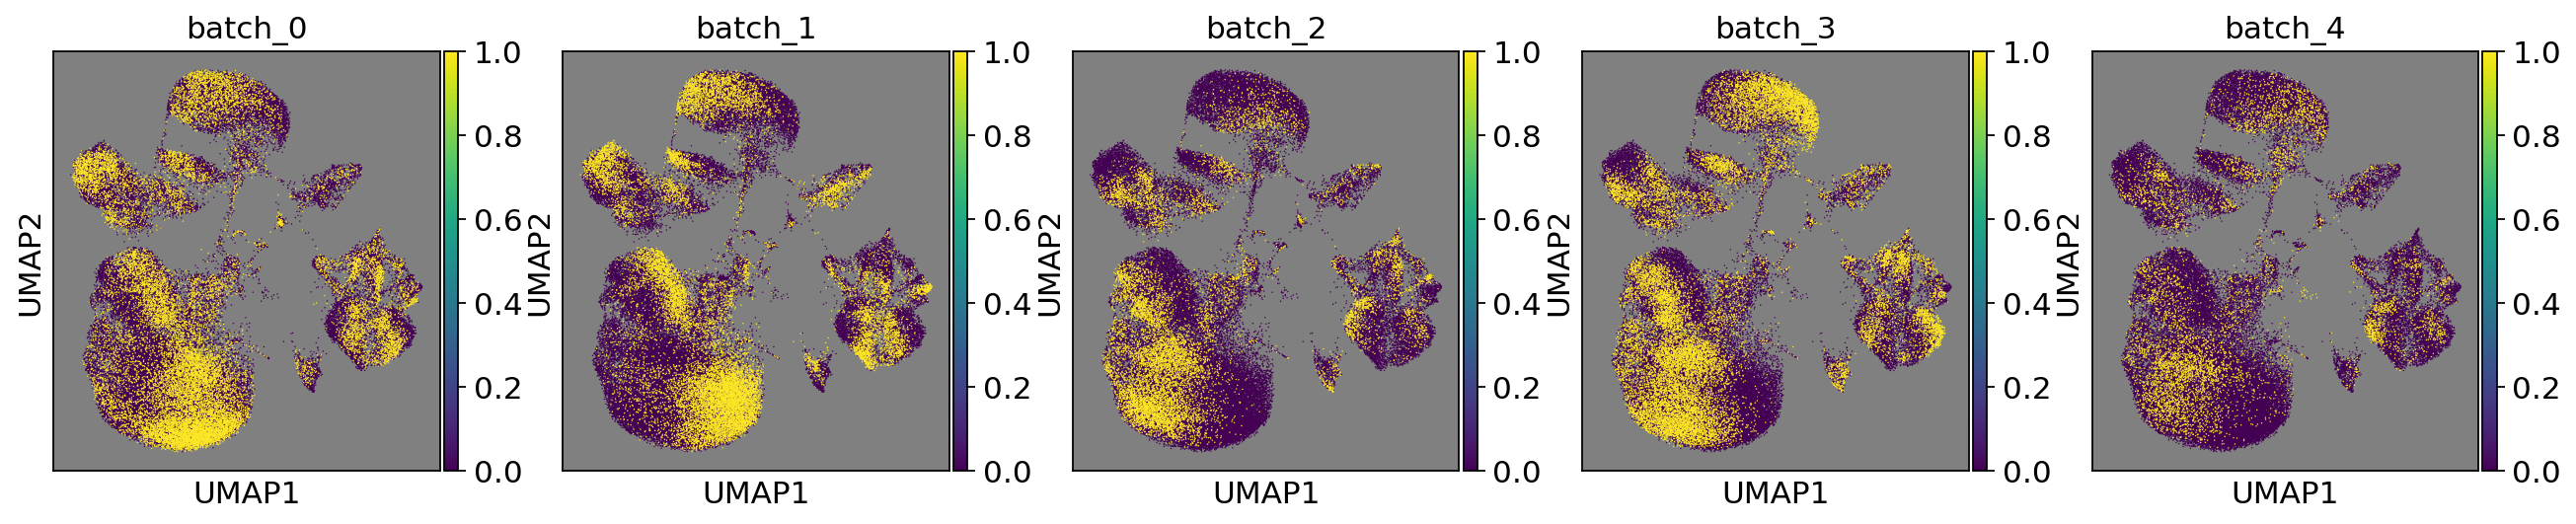

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(20,3.5))
# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch, ax in zip(batches, np.ravel(ax)):
    ax.set_facecolor('gray')
    sc.pl.umap(concat, color=['batch_%s' % batch], ax=ax, sort_order=True, show=False, return_fig=False)

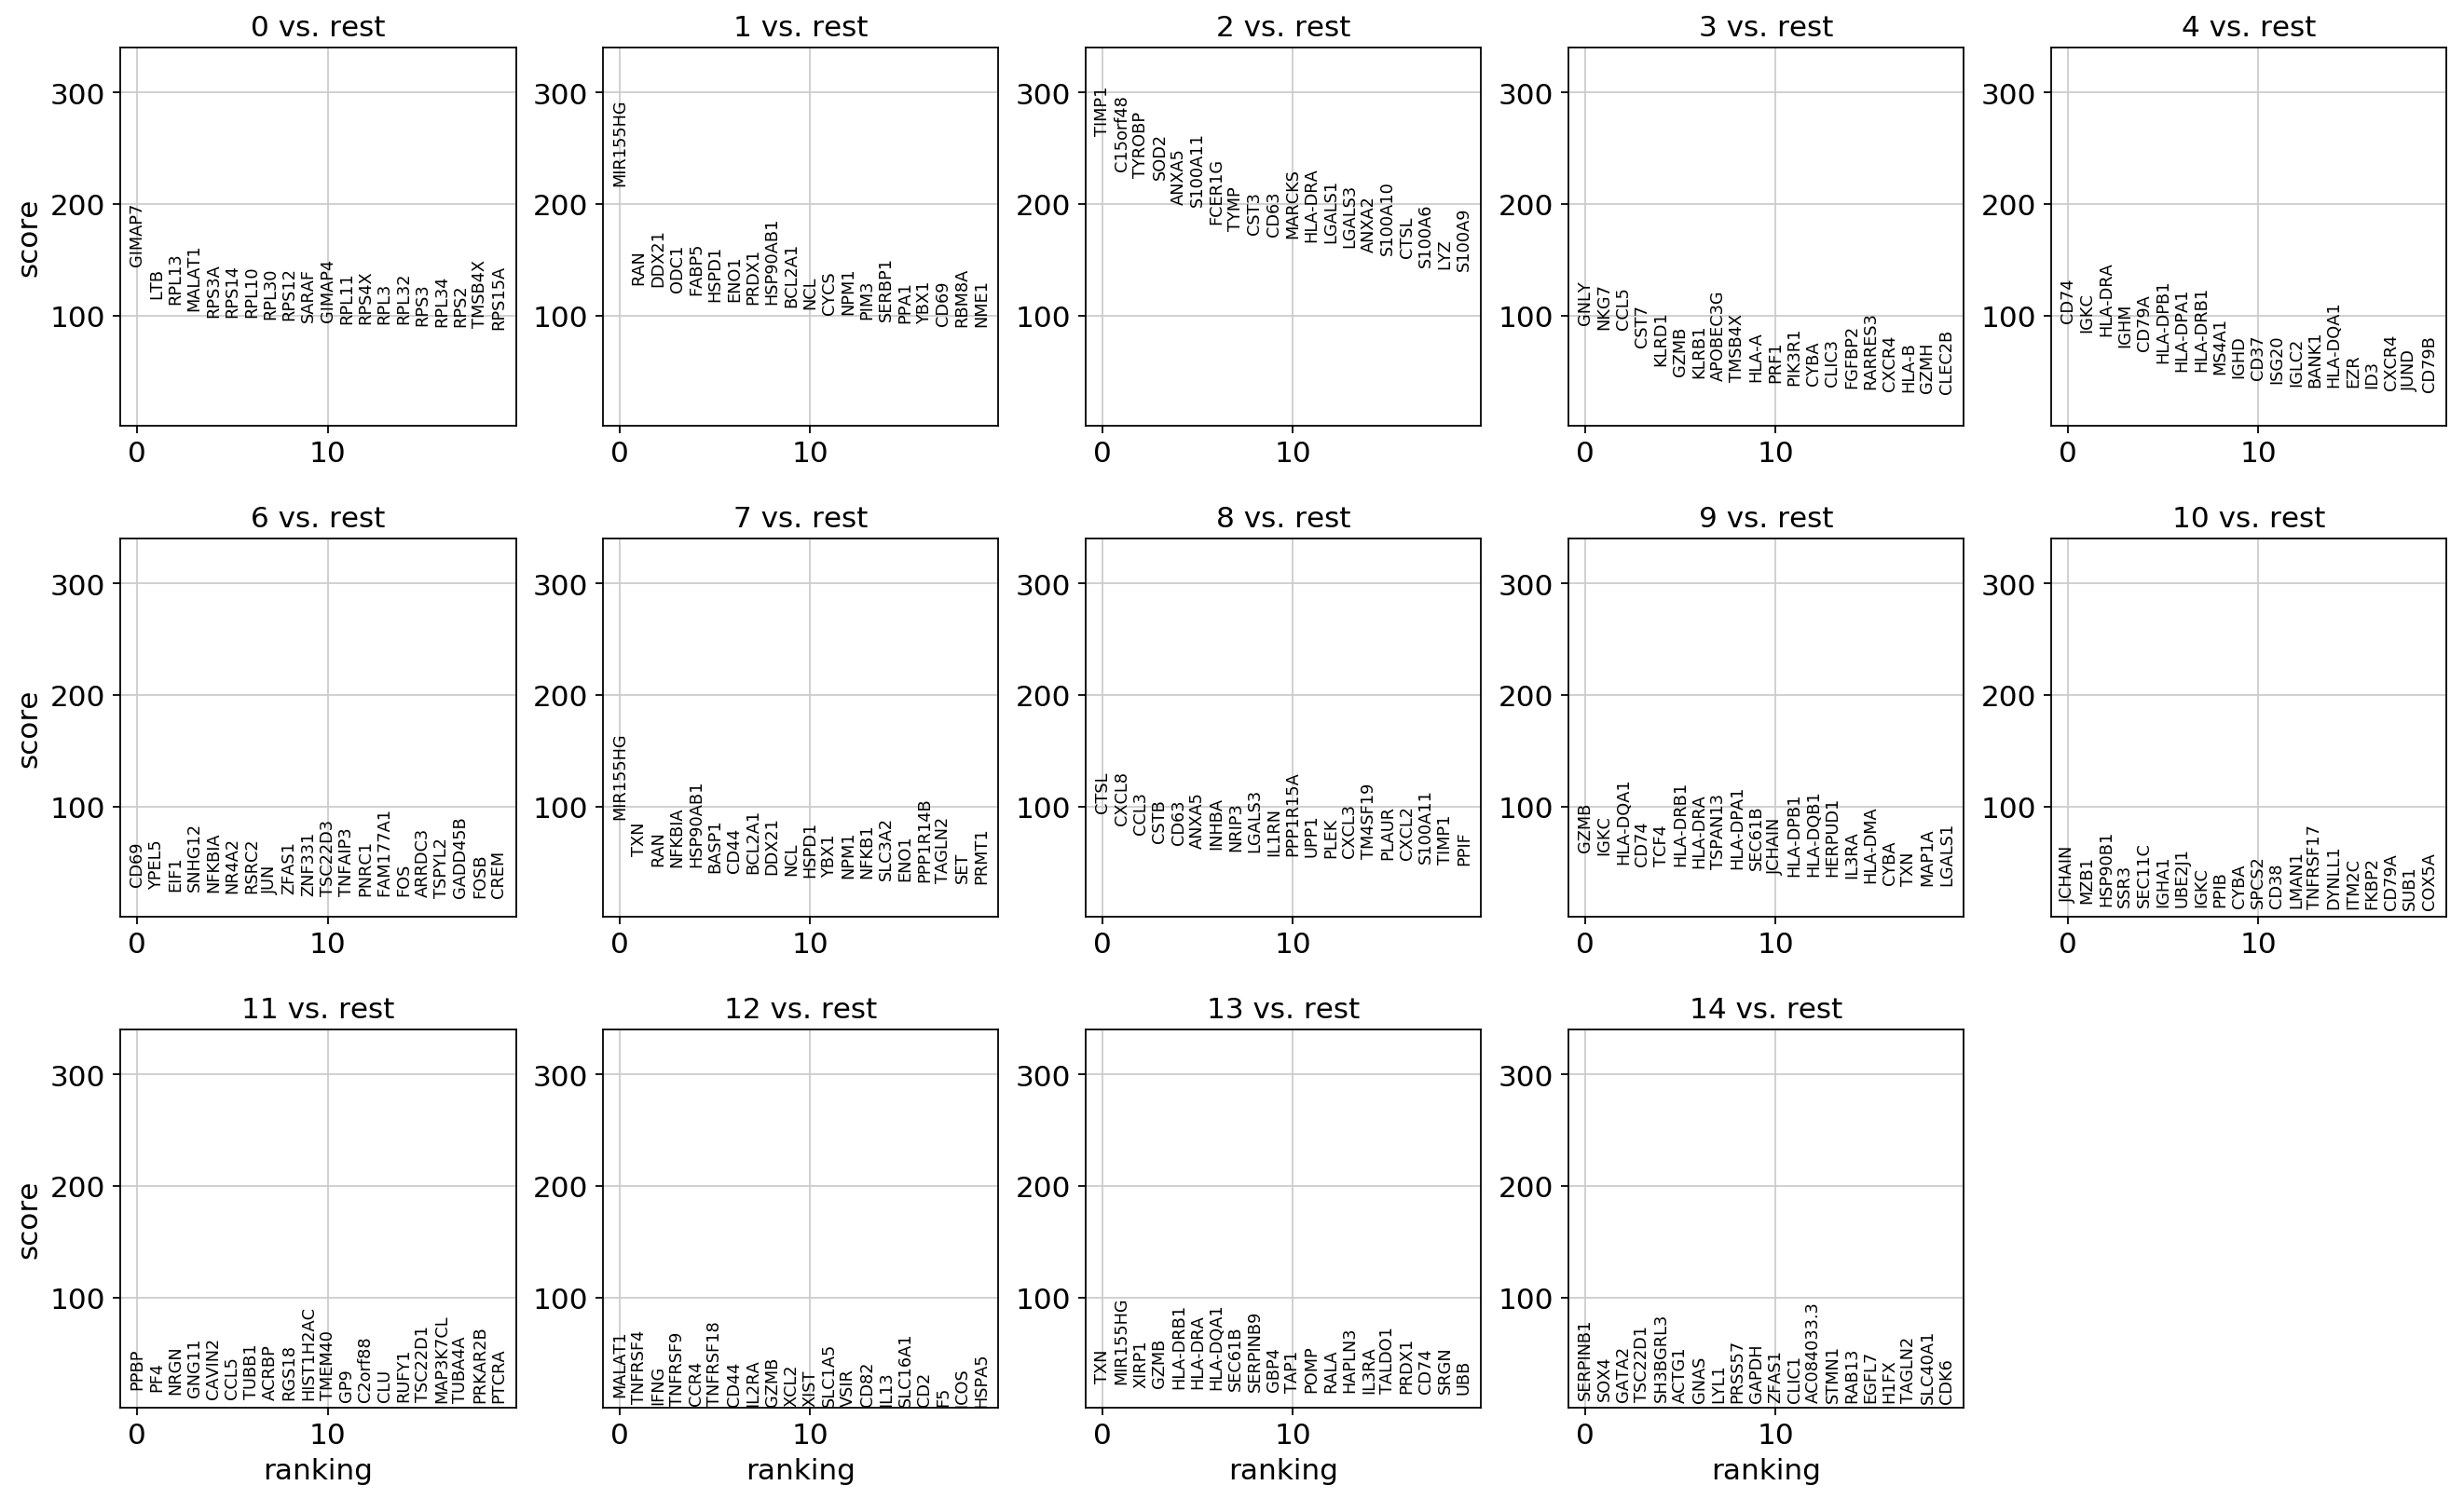

In [8]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

In [10]:
def get_dge(adata):
    deg_data = pd.DataFrame() 
    for i in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']:
        deg_data[i] = np.array(adata.uns['rank_genes_groups'][i].tolist()).flatten()
    return deg_data

In [11]:
get_dge(concat)

,scores,names,logfoldchanges,pvals,pvals_adj
0,144.549072,GIMAP7,NaN,0.000000e+00,0.000000e+00
1,216.743317,MIR155HG,NaN,0.000000e+00,0.000000e+00
2,261.882904,TIMP1,NaN,0.000000e+00,0.000000e+00
3,91.851730,GNLY,NaN,0.000000e+00,0.000000e+00
4,93.779442,CD74,NaN,0.000000e+00,0.000000e+00
...,...,...,...,...,...
1395,5.913473,WARS,NaN,1.291925e-08,1.932461e-06
1396,2.742794,NEXN,10.604879,6.772932e-03,7.506062e-01
1397,1.487807,SUMO4,8.118089,1.401775e-01,1.000000e+00
1398,8.364100,EIF5,9.946939,1.843272e-15,2.729867e-13


In [65]:
concat_unstim_bcs = concat.obs[concat.obs['COND'] == 'UNSTIM'].index.values

In [67]:
path = prefix + 'pkls/concat.freemuxed.pkl'

with open(path,'rb') as file:
    concat_unstim = pkl.load(file)[concat_unstim_bcs,:].copy()

In [68]:
sc.pp.normalize_per_cell(concat_unstim, counts_per_cell_after=1e6)

In [69]:
sc.pp.log1p(concat_unstim)

Try without combat first.

### Highly-variable Gene Extraction

In recent times, I have been forgoing highly-variable gene extraction because I thought it was just a measure to reduce total size of the matrix so that PCA and subsequent steps were computationally feasible. With AWS, memory and speed considerations are not that critical for me, and so I've generally opted to just keep mostly all genes (barring the small percentage that are barely expressed at all). However, Jessica Neely has mentioned that when she forgoes it, she starts to see some batch effects from some of her wells, and since I ran this pipeline at first and was getting some batch effects, I figured I'd try the variable gene extraction and see if it helps ameliorate the batch effect. Unfortunately it did not, so I'm just going to remove those cells because I'm pretty sure they would be identified by a doublet finder algorithm. We can do that at a later date.

In [49]:
# import matplotlib.patches as patches
# from shapely.geometry import Point
# from shapely.geometry.polygon import Polygon

# def hv_run(adata, flavor='cell_ranger', min_mean=0.0125, min_disp=0.5, max_mean=3, bins=500):    # Extract out highly variable genes, but don't subset just yet
#     '''
#     Run highly variable genes and return a new adata object, if provided.
#     '''
#     hv_adata = adata.copy() # make a copy because I don't want to change the original just yet
#     sc.pp.highly_variable_genes(hv_adata, flavor=flavor,inplace=True, 
#                                 min_mean=min_mean, 
#                                 min_disp=min_disp, 
#                                 max_mean=max_mean,
#                                 n_bins=bins)
    
#     means = hv_adata.var['means'].values
#     means_sorted = np.unique(np.sort(means))
#     if means_sorted[0] == 0:
#         mean_shift = means_sorted[1]
#     elif means_sorted[0] < 0:
#         mean_shift = means_sorted[1] - 2*means_sorted[0]
#     else:
#         mean_shift = 0
    
#     disps = hv_adata.var['dispersions_norm'].values
#     disps_sorted = np.unique(np.sort(disps))
#     if disps_sorted[0] == 0:
#         disp_shift = disps_sorted[1]
#     elif disps_sorted[0] < 0:
#         disp_shift = disps_sorted[1] - 2*disps_sorted[0]
#     else:
#         disp_shift = 0
        
#     log_means = np.log10(means + mean_shift)
#     log_disps = np.log10(disps + disp_shift)
    
#     hv_adata.var['log_means'] = log_means
#     hv_adata.var['log_disps'] = log_disps
    
#     return hv_adata

# def hv_plot(hv_adata, gate=None, highlight_genes=None):
#     '''
#     Plot the means and normalized dispersions from the adata object provided. Choose to
#     also plot a gate or highlight certain genes.
#     '''
#     plt.figure(figsize=(7,7)) # make a figure
#     plt.minorticks_on() # throw on the minor ticks for use with the grid, will help with subsetting
#     plt.grid(True,which='both',axis='both') # turn the grid on
    
#     # do what the scanpy function does, plotting normalized dispersions with means as blue dots, 
#     # I don't want to plot in logspace but I don't want to use the log function because then the gates don't work
#     # if they contain segments with fractional slopes (i.e. non-straight lines). To be robust to these gates, I therefore 
#     # will log10 everything and just plot in linear space
#     log_means = hv_adata.var['log_means'].values
#     log_disps = hv_adata.var['log_disps'].values
    
#     plt.scatter(log_means, log_disps, s=0.5, c='b')
#     if type(highlight_genes) != type(None): # do you want to highlight some genes?
#         mask = [i in highlight_genes for i in hv_adata.var_names] # create a boolean mask of which genes to highlight
#         highlight_means = log_means[mask] # subset only those means
#         highlight_disps = log_disps[mask] # subset only those dispersions
#         plt.scatter(highlight_means,highlight_disps,s=30, facecolors='none', edgecolors='r'); # plot with a red circle around the blue dot
#     if type(gate) != type(None):
#         # You can draw a gate around the genes you want. There should be a check for using only rectangular gates (or only polygons with right angles). 
#         # I have noted that if you try to draw angled lines in log space using the shapely package, the points_in_poly function does not return the right subset of points within the polygon.
#         ax = plt.gca() # if you want to add a gate
#         gatepatch = patches.Polygon(gate,linewidth=1,edgecolor='teal',facecolor='turquoise',alpha=0.5) # create a matplotlib patch for the gate to the plot
#         ax.add_patch(gatepatch); # add the gate to the plot

# def hv_genes(hv_adata, gate, adata=None):
#     '''
#     Receive boolean for genes in gate or new subsetted adata object, if provided.
#     '''
#     # You can subset the genes you want using the gate. Again, there should be a check for using only rectangular gates (or only polygons with right angles). 
#     # I have noted that if you try to draw angled lines in log space using the shapely package, the points_in_poly function does not return the right subset of points within the polygon.
#     genes = list()
#     log_means = hv_adata.var['log_means'].values
#     log_disps = hv_adata.var['log_disps'].values
    
#     pointsmap = map(Point,log_means,log_disps) # make each point a shapely.geometry.Point
    
#     polygon = Polygon(gate) # make your gate a shapely.geometry.Polygon
#     for i in pointsmap:
#         genes.append(polygon.contains(i)) # this is the workhorse, determining which points are in the gate
#     if type(adata) != type(None): # if the adata has been provided, subset it
#         adata = adata[:,genes].copy()
#         return adata
#     else: # if it has not been provided return the boolean array noting which genes will be kept
#         return genes

# Generate a "highly variable adata" object that has run the highly variable genes extraction function. I generate a separate object because I don't want to necessarily change the original object.

# hv_adata = hv_run(concat)

# With the `hv_plot()` function, you can see the whole distribution:

# hv_plot(hv_adata)

# hv_plot(hv_adata, highlight_genes= ['CD8A', 'CD8B', 'CD3D', 'ANK3', 'IL7R', 'CD14','LYZ','CCL2',
#                          'S100A9', 'FCGR3A','MS4A7','VMO1', 'CD19','MS4A1','CD79A', 'KLRF1', 'GNLY', 
#                          'NKG7', 'HLA.DQA1','FCER1A','GPR183', 'CLEC4C','TSPAN13','IGJ', 'PPBP','GNG11'])

# You can draw a gate around the genes you want. There should be a check for using only rectangular gates (or only polygons with right angles). I have noted that if you try to draw angled lines in log space using the shapely package, the points_in_poly function does not return the right subset of points within the polygon.

# xrange = (-1.8, 1.1)
# yrange = (-0.6, 1.2)
# gate = np.array([(xrange[0], yrange[0]), 
#                   (xrange[0], yrange[1]), 
#                   (xrange[1], yrange[1]), 
#                   (xrange[1], yrange[0])])

# hv_plot(hv_adata, gate=gate, highlight_genes= ['CD8A', 'CD8B', 'CD3D', 'ANK3', 'IL7R', 'CD14','LYZ','CCL2',
#                          'S100A9', 'FCGR3A','MS4A7','VMO1', 'CD19','MS4A1','CD79A', 'KLRF1', 'GNLY', 
#                          'NKG7', 'HLA.DQA1','FCER1A','GPR183', 'CLEC4C','TSPAN13','IGJ', 'PPBP','GNG11'])

# You can extract a boolean array of the genes you want:

# genes = hv_genes(hv_adata, gate=gate)

# genes[:10]

# concat.var_names[genes][:10].values

# You can check how many you have:

# sum(genes)

# concat.shape

# You can get a new adata object with your genes now subsetted:

# concat = hv_genes(hv_adata, gate=gate, adata=concat)

# concat.shape

### Dimensionality Reduction and Clustering

In [70]:
sc.pp.scale(concat_unstim)

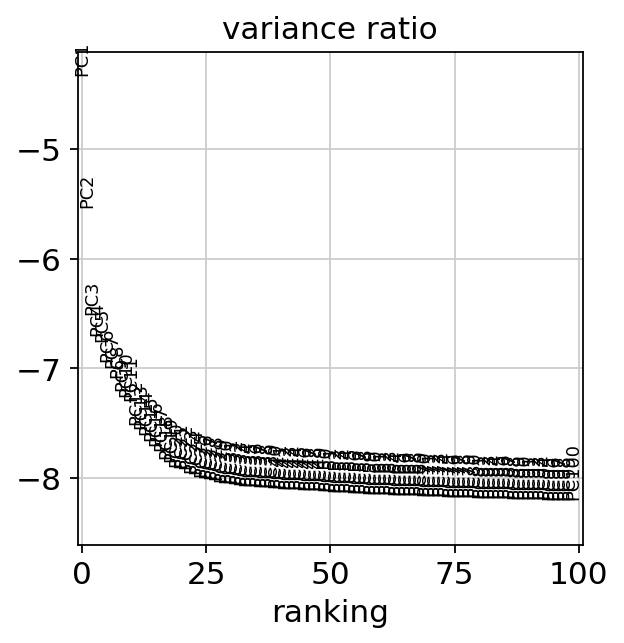

In [71]:
warnings.filterwarnings('ignore')
sc.pp.pca(concat_unstim,n_comps=100)
sc.pl.pca_variance_ratio(concat_unstim,log=True, n_pcs=100)
warnings.filterwarnings('default')

In [72]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat_unstim,n_neighbors=15,n_pcs=35) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

In [73]:
sc.tl.umap(concat_unstim)

In [74]:
sc.tl.leiden(concat_unstim,resolution=0.2)

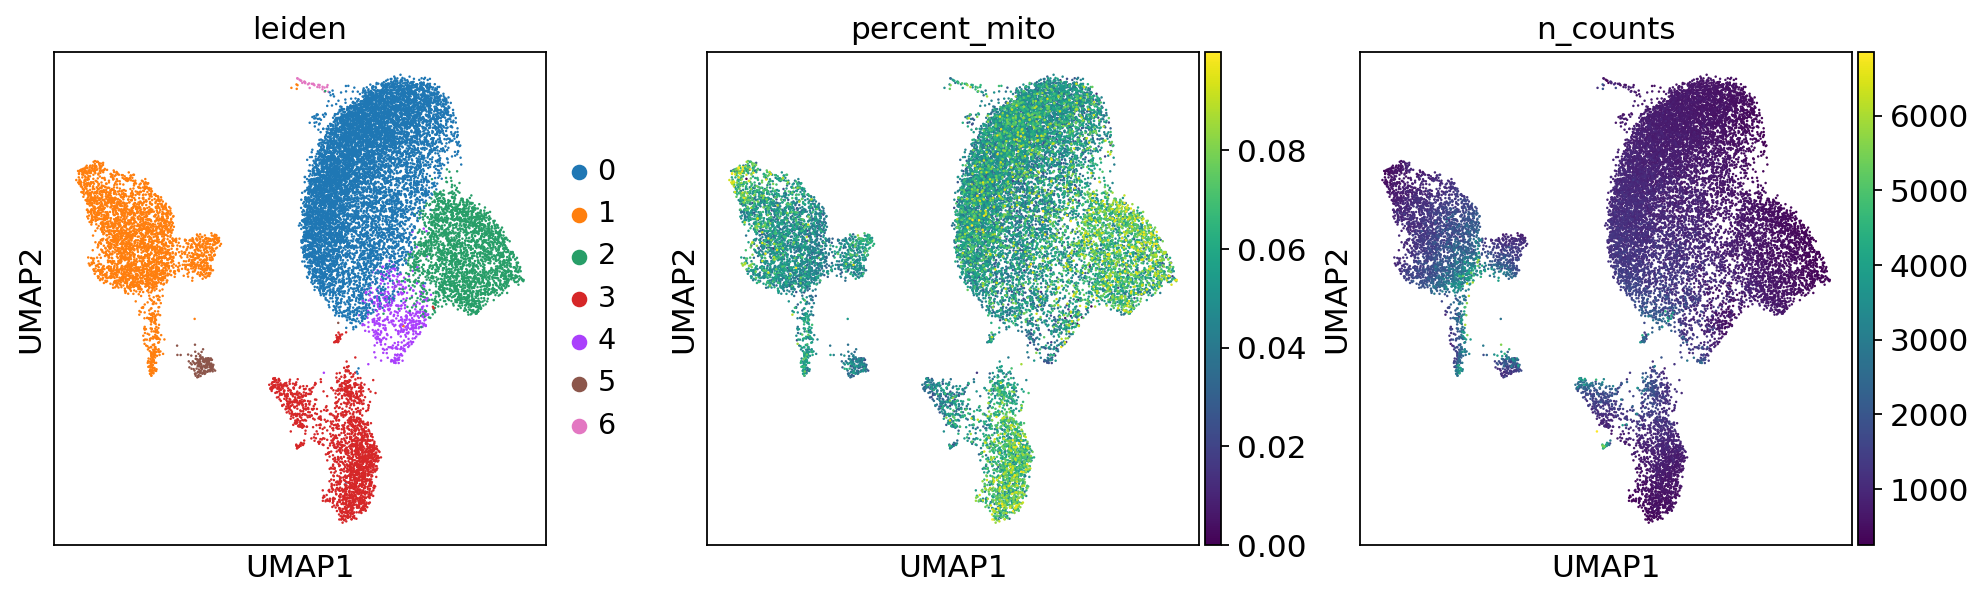

In [79]:
sc.pl.umap(concat_unstim,color=['leiden', 'percent_mito', 'n_counts'], size=5);

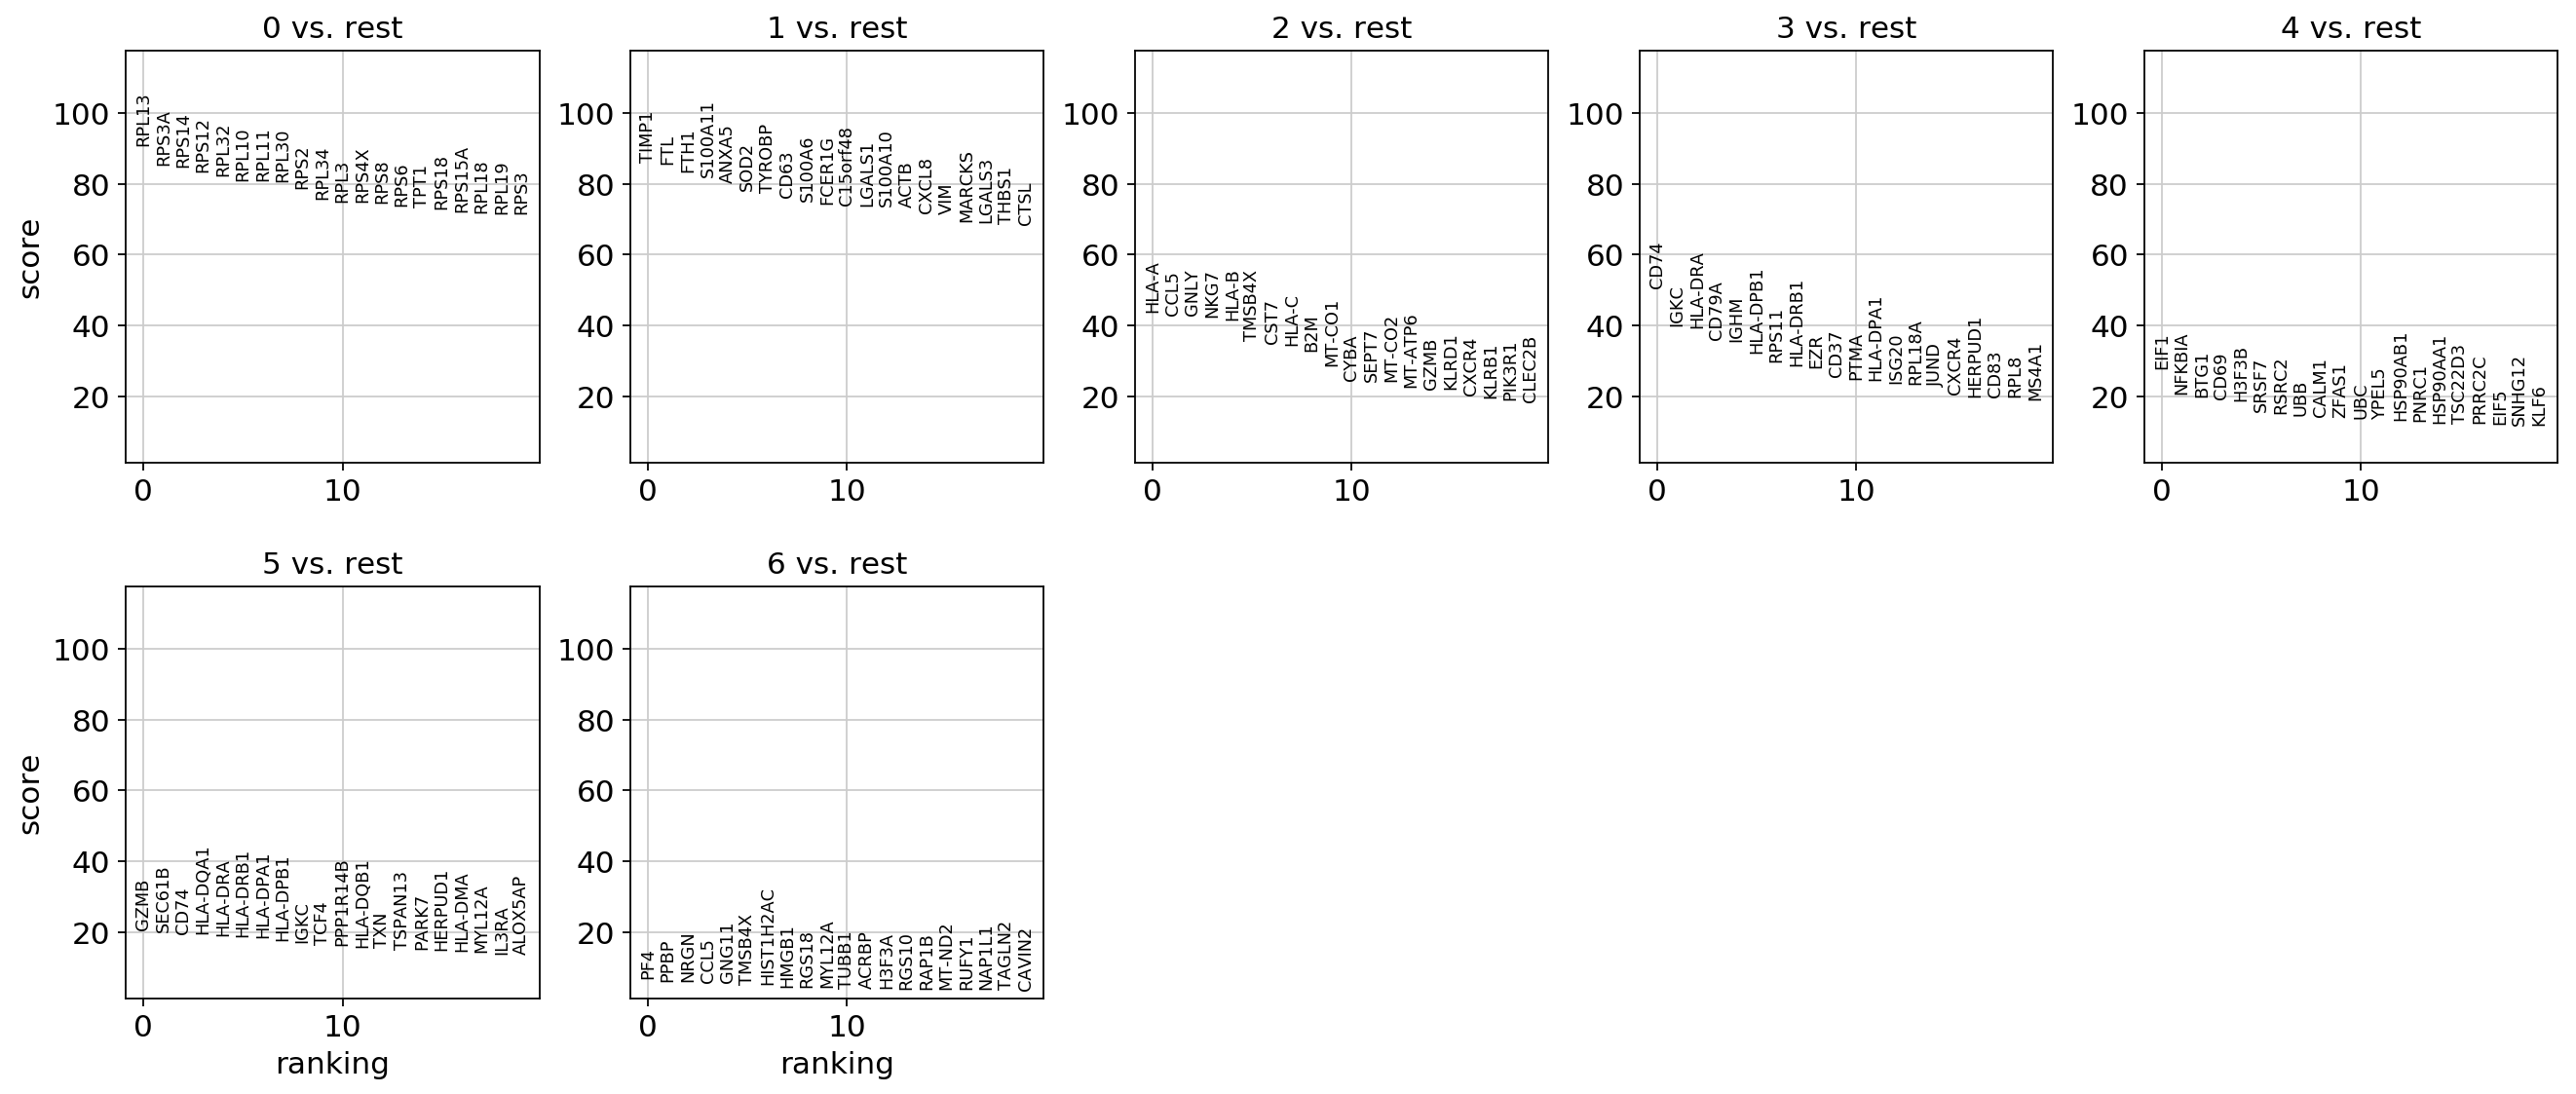

In [90]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_unstim, groupby='leiden', method='wilcoxon')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat_unstim, ncols=5)
sc.settings.verbosity = 4

In [91]:
get_dge(concat_unstim)['logfoldchanges']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
695   NaN
696   NaN
697   NaN
698   NaN
699   NaN
Name: logfoldchanges, Length: 700, dtype: float64

In [45]:
sc.pp.pca(concat_unstim)

In [45]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_unstim, groupby='leiden', method='wilcoxon')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat_unstim, ncols=5)
sc.settings.verbosity = 4

ZeroDivisionError: division by zero

In [36]:
concat_unstim

In [36]:
ctdict = dict()
for i in range(len(groupings)):
    ctdict['ct%s' % str(i)] = groupings[i]

sub_concats['5'].obs['celltype'] = sub_concats['5'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        sub_concats['5'].obs['celltype'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
sub_concats['5'].obs['leiden'] = [i.strip('ct') for i in sub_concats['5'].obs['celltype'].astype('category')]

In [37]:
def sub_cluster_mapper(adata, sub_adatas):
    '''
    This takes in the adata object and inserts a new leiden column in the `.obs`. 
    
    This function is really convoluted and there's probably a better, simpler way to do it,
    but it should theoretically work for any number of subclusters
    '''
    # ideally you'd make a copy of the adata object here, so we don't have to change the original
    # this would be in case we want to run it multiple times, perhaps the resolutions we put in didn't subset the clusters like we had hoped
    # and we need to run multiple times to adjust the resolution slightly
    
    # this block is to figure out that there are two new subclusters and they should be named 8, 9
    total_new_clusts = 0
    old_clusts = sub_adatas.keys()
    for sub_adata in sub_adatas:
        total_new_clusts += sub_adatas[sub_adata].obs['leiden'].astype(int).unique().max() + 1
    total_added_clusts = total_new_clusts - len(sub_adatas)
    new_clust_names_start = max(adata.obs['leiden'].astype(int))+1
    new_added_clust_names = [str(i) for i in range(new_clust_names_start,
                                                   new_clust_names_start + total_added_clusts)]
    
    # this block is to build a new list of leiden clusters from the old one 
    new_leiden = list()
    leiden_col = adata.obs['leiden'].copy()

    # this builds the new leiden cluster list, now adding a .1, .2, etc. to each new cluster
    for obs in leiden_col.index:
        clust_name = leiden_col.loc[obs]
        if clust_name not in old_clusts or sub_adatas[clust_name].obs.loc[obs, 'leiden'] == '0':
            new_leiden.append(clust_name)
        else:
            new_leiden.append(clust_name + '.%s' % sub_adatas[clust_name].obs.loc[obs,'leiden'])

    # this renames the .1, .2, etc clusters to the new, better names I came up with above (8 and 9)
    new_leiden = pd.Series(new_leiden, index=adata.obs_names)
    added_clusts = np.setdiff1d(new_leiden,adata.obs['leiden'])
    new_leiden.replace(dict(zip(added_clusts, new_added_clust_names)), inplace=True)
    
    # replace the old leiden column, must do these steps sequentially 
    adata.obs['leiden'] = new_leiden.astype(int) # to order the clusters by number
    adata.obs['leiden'] = new_leiden.astype(str) # to convert to string as normal
#     adata.obs['leiden'] = new_leiden.astype('category') # don't do this, it messes things up, just let scanpy do it as it plots
    return adata

In [38]:
concat = sub_cluster_mapper(concat, sub_concats)

In [39]:
path = prefix + 'h5ads/concat.freemuxed.dimred.check.h5ad'
 
concat.write_h5ad(path)
concat = sc.read_h5ad(path)

... storing 'leiden' as categorical
